<a href="https://colab.research.google.com/github/apoorvaec1030/Data-Science-projects/blob/main/retail_transaction_dataset_play.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("fahadrehman07/retail-transaction-dataset")
print("Path to dataset files:", path)


100%|██████████| 5.26M/5.26M [00:00<00:00, 88.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fahadrehman07/retail-transaction-dataset/versions/1


In [3]:
df=pd.read_csv(path+'/'+'Retail_Transaction_Dataset.csv')

# **Ensure Data integrity and quality**
1. Convert to correct datatypes
2. Handle missing values
3. Remove duplicates
4. Detect outliers

In [ ]:
def correct_datatype(df):
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')  # Ensure valid datetime
  df['CustomerID'] = df['CustomerID'].astype(str)  # Ensure ID is treated as a string
  df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
  df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
  df['DiscountApplied(%)'] = pd.to_numeric(df['DiscountApplied(%)'], errors='coerce')
  df['TotalAmount'] = pd.to_numeric(df['TotalAmount'], errors='coerce')
  return df

df=correct_datatype(df)

In [55]:
#check discount is properly applied
assert len(df)==(np.round(df['Price']*df['Quantity']*(1-df['DiscountApplied(%)']*0.01))==np.round(df['TotalAmount'])).sum()


In [56]:
import numpy as np

# ✅ Outlier Detection (Using IQR) because the data is skewed for total amount
def detect_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))][column]

outliers = {}
for col in ['Quantity', 'Price', 'TotalAmount','DiscountApplied(%)']:
    outliers[col] = detect_outliers(col)

print("Outliers detected:\n", outliers)



Outliers detected:
 {'Quantity': Series([], Name: Quantity, dtype: int64), 'Price': Series([], Name: Price, dtype: float64), 'TotalAmount': 107      791.906223
464      881.155400
496      763.691639
662      787.540655
663      771.179815
            ...    
99569    844.095797
99607    795.357871
99732    784.386168
99762    785.735978
99975    802.241629
Name: TotalAmount, Length: 853, dtype: float64, 'DiscountApplied(%)': Series([], Name: DiscountApplied(%), dtype: float64)}


In [ ]:
import sys
!{sys.executable} -m pip install -U ydata-profiling[notebook]
!pip install jupyter-contrib-nbextensions

In [14]:
from ydata_profiling import ProfileReport

ProfileReport(df,title="Profiling Report")
#0missing, 0duplicates

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# **1️⃣ Basic Sales Analysis (EDA)**

1. Find total revenue, average order value, and number of transactions.
2. Identify top-selling products and most profitable store locations.
3. Use visualizations (bar charts, heatmaps) to summarize key findings.

In [41]:
#Find total revenue
total_revenue=sum(df['TotalAmount'])

print(f'total revenue:{np.round(total_revenue)}')

#revenue per customer
rev_per_customer=df.groupby(['CustomerID'])['TotalAmount'].sum().reset_index()
avg_cust_rev=np.mean(rev_per_customer['TotalAmount'])
print(f'revenue per customer :{np.round(avg_cust_rev)}')

#average order value
rev_per_order=df.groupby(['CustomerID','TransactionDate'])['TotalAmount'].sum().reset_index()
avg_order_rev=np.mean(rev_per_order['TotalAmount'])
print(f'revenue per order :{np.round(avg_order_rev)}')

#Identify top3-selling products
top_sellers=df.groupby(['ProductID'])['TotalAmount'].sum().sort_values(ascending=False).reset_index()
np.array(top_sellers['ProductID'][:3])

#most profitable store locations
df.loc[df['TotalAmount'].sort_values(ascending=False)[:3].index,['StoreLocation','TotalAmount']]

#least profitable store locations
df.loc[df['TotalAmount'].sort_values(ascending=True)[:3].index,['StoreLocation','TotalAmount']]

total revenue:24833496.0
revenue per customer :261.0
revenue per order :248.0


,StoreLocation,TotalAmount
74087,"68518 Paula Knoll\nNorth Crystalborough, NV 46524",8.274825
18430,"44367 Fleming Locks\nLake Nicholasborough, MN ...",8.359100
34606,"5087 Deborah Alley Apt. 030\nMaddenfort, AS 58600",8.360628


## 3️⃣ **Discount Effectiveness Analysis**
1. Compare sales with and without discounts to determine if discounts increase revenue.
2. Analyze how discount percentage affects total sales.

In [66]:
#Compare sales with and without discounts to determine if discounts increase revenue.

prediscount_rev=np.round((df['Price']*df['Quantity']).sum())
current_rev=np.round(df['TotalAmount'].sum())

print(f'{prediscount_rev} vs {current_rev}')

no_discount_tranx=len(df.loc[np.round(df['DiscountApplied(%)'])==0,['TotalAmount','DiscountApplied(%)']])
print(f'no discount tranx: {no_discount_tranx} is very less to perform any comparison')

27596800.0 vs 24833496.0
no discount tranx: 2456 is very less to perform any comparison


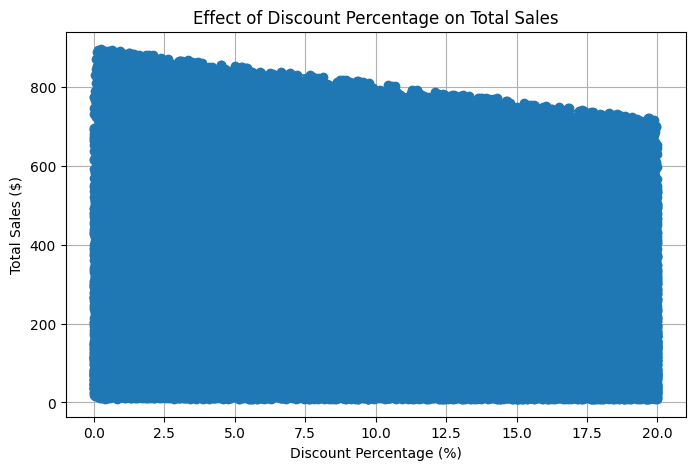

Conclusion: highest ticketed items were not purchased for discounts


In [78]:
#Analyze how discount percentage affects total sales.

import matplotlib.pyplot as plt

# 📈 Plotting the relationship
plt.figure(figsize=(8, 5))
plt.plot(df['DiscountApplied(%)'], df['TotalAmount'], marker='o')

# 📌 Formatting
plt.xlabel("Discount Percentage (%)")
plt.ylabel("Total Sales ($)")
plt.title("Effect of Discount Percentage on Total Sales")
plt.grid(True)
plt.show()

print(f'Conclusion: highest ticketed items were not purchased for discounts')

# 5️⃣ **Time-Based Sales Forecasting**
Analyze sales trends over time (e.g., daily, weekly, monthly).
Use seasonality analysis to detect peak shopping times.

<Axes: >

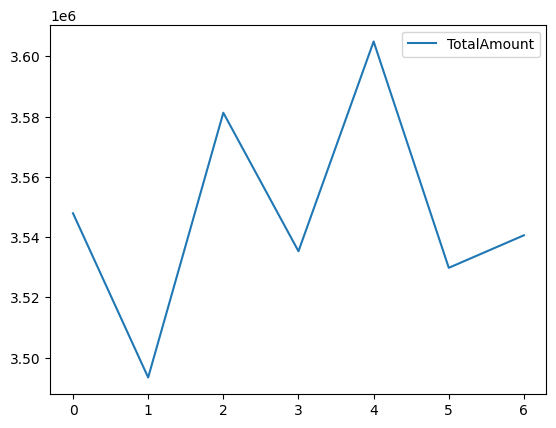

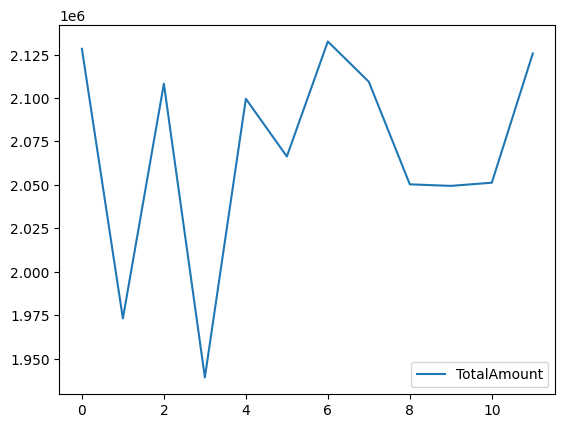

In [88]:
from datetime import datetime as dt

df['day_of_week'] = [date.strftime('%A') for date in df['TransactionDate']]
df['tranx_month'] = [date.strftime('%m') for date in df['TransactionDate']]


df.groupby(['day_of_week'])['TotalAmount'].sum().reset_index().plot()
df.groupby(['tranx_month'])['TotalAmount'].sum().reset_index().plot()

# **7️⃣ Customer Segmentation (Clustering)**
Use K-Means or DBSCAN clustering on TotalAmount, Quantity, and DiscountApplied(%) to segment customers.
Identify high-value customers vs. bargain shoppers.


---

## **🔹 Easy Projects (Beginner-Friendly)**
### 1️⃣ **Basic Sales Analysis (EDA)**
   - Find **total revenue, average order value, and number of transactions**.
   - Identify **top-selling products** and **most profitable store locations**.
   - Use visualizations (bar charts, heatmaps) to summarize key findings.

### 2️⃣ **Customer Purchase Behavior Analysis**
   - Identify **most frequent buyers** based on `CustomerID`.
   - Calculate **average spending per customer**.
   - Analyze which **product categories** are most popular.

### 3️⃣ **Discount Effectiveness Analysis**
   - Compare **sales with and without discounts** to determine if discounts increase revenue.
   - Analyze **how discount percentage affects total sales**.

---

## **🔹 Medium Projects (Intermediate Level)**
### 4️⃣ **Payment Method Preference Analysis**
   - Identify **which payment methods are most used**.
   - Find correlations between **payment method and total spending**.

### 5️⃣ **Time-Based Sales Forecasting**
   - Analyze **sales trends over time** (e.g., daily, weekly, monthly).
   - Use **seasonality analysis** to detect peak shopping times.

### 6️⃣ **Store Performance Analysis**
   - Compare stores based on **revenue, transaction count, and discount usage**.
   - Identify **which store locations underperform and why**.

---

## **🔹 Hard Projects (Advanced Level)**
### 7️⃣ **Customer Segmentation (Clustering)**
   - Use **K-Means or DBSCAN** clustering on `TotalAmount`, `Quantity`, and `DiscountApplied(%)` to segment customers.
   - Identify **high-value customers vs. bargain shoppers**.

### 8️⃣ **Market Basket Analysis (Association Rules)**
   - Find **frequently bought-together products** using **Apriori or FP-Growth algorithms**.
   - Recommend **cross-selling opportunities**.

### 9️⃣ **Dynamic Pricing Model**
   - Build a **pricing optimization model** that suggests ideal prices based on **demand, seasonality, and discount trends**.

---

## **🔹 Very Hard Projects (Expert Level)**
### 🔟 **Predicting Customer Churn**
   - Identify **patterns in purchasing behavior** to predict **which customers are likely to stop buying**.
   - Use **classification models** (Logistic Regression, XGBoost).

### 1️⃣1️⃣ **Sales Forecasting with Deep Learning**
   - Use **LSTMs (Long Short-Term Memory Networks)** to **forecast future sales** based on historical transactions.

### 1️⃣2️⃣ **Fraud Detection in Transactions**
   - Detect unusual transactions using **Anomaly Detection (Isolation Forest, Autoencoders)**.
   - Flag **suspicious purchases** based on **high discounts, large quantities, or unusual locations**.

---



---

### **🔹 Core Projects for Marketing Data Science**
#### **1️⃣ Customer Segmentation (Essential for Targeted Marketing)**
   - **Goal:** Group customers based on purchasing behavior.
   - **Techniques:** K-Means, Hierarchical Clustering, DBSCAN.
   - **Key Features:** `TotalAmount`, `Quantity`, `DiscountApplied(%)`, `StoreLocation`.
   - **Marketing Use Case:** Personalized promotions, targeted advertising.

#### **2️⃣ Predicting Customer Churn (Retention Strategy)**
   - **Goal:** Identify customers likely to stop purchasing.
   - **Techniques:** Logistic Regression, Random Forest, XGBoost.
   - **Key Features:** `TransactionDate` (recency), `TotalAmount`, `DiscountApplied(%)`, `ProductCategory`.
   - **Marketing Use Case:** Create retention campaigns for high-churn risk customers.

#### **3️⃣ Market Basket Analysis (Product Recommendation)**
   - **Goal:** Find frequently bought-together products.
   - **Techniques:** Apriori, FP-Growth (Association Rule Mining).
   - **Key Features:** `CustomerID`, `ProductID`, `Quantity`.
   - **Marketing Use Case:** Cross-selling, upselling strategies.

#### **4️⃣ Price Sensitivity Analysis (Optimizing Pricing Strategies)**
   - **Goal:** Understand how discounts impact sales.
   - **Techniques:** Regression models (OLS, Ridge), A/B Testing.
   - **Key Features:** `Price`, `DiscountApplied(%)`, `TotalAmount`.
   - **Marketing Use Case:** Dynamic pricing strategies.

#### **5️⃣ Predicting Sales Volume (Demand Forecasting)**
   - **Goal:** Forecast future sales to optimize inventory and marketing spend.
   - **Techniques:** ARIMA, Prophet, LSTMs.
   - **Key Features:** `TransactionDate`, `Quantity`, `Price`, `StoreLocation`.
   - **Marketing Use Case:** Budget allocation for ads and promotions.

---

### **🔹 Advanced Data Science Challenges for Senior Roles**
#### **6️⃣ Marketing Mix Modeling (MMM)**
   - **Goal:** Measure the impact of marketing channels (ads, discounts, seasonality).
   - **Techniques:** Multi-linear regression, Bayesian MMM.
   - **Key Features:** `TotalAmount`, `DiscountApplied(%)`, external data (ad spend, social media metrics).
   - **Marketing Use Case:** Optimize ad budgets across multiple channels.

#### **7️⃣ Customer Lifetime Value (CLV) Prediction**
   - **Goal:** Estimate a customer's future spending value.
   - **Techniques:** Pareto/NBD model, LTV regression.
   - **Key Features:** `CustomerID`, `TransactionDate`, `TotalAmount`.
   - **Marketing Use Case:** Identify high-value customers for loyalty programs.

#### **8️⃣ A/B Testing for Marketing Campaigns**
   - **Goal:** Evaluate the impact of discounts or ad campaigns.
   - **Techniques:** Hypothesis testing (t-tests, chi-square).
   - **Key Features:** `TotalAmount`, `DiscountApplied(%)`, `ProductCategory`.
   - **Marketing Use Case:** Data-driven decision-making for promotions.

---
